# Telecom Customer Churn Prediction with Survival Analysis

## Introduction
Customer churn is one of the most critical challenges in the telecom industry. Traditionally, churn analysis is approached as a **binary classification problem** (Will the customer churn: Yes/No).  
However, businesses don’t just need to know *if* a customer will churn — they need to know **when** the churn is most likely to happen.  

This project uses **survival analysis** to estimate the **customer lifetime** and identify **risk windows** where churn is most likely to occur.  
By doing so, telecom companies can design **targeted retention campaigns**, offer **discounts at the right time**, and **reduce revenue losses**.

---

## Problem Statement
The goal of this project is to:
- Estimate how long a customer is likely to stay with the company (customer lifetime).
- Identify the time periods when churn risk is highest.
- Understand the impact of customer behavior (contract type, billing method, complaints, usage, payments, etc.) on churn survival.
- Provide actionable insights for business teams to **improve retention strategies**.

In other words, instead of just predicting *who will churn*, this project answers:
- **When will the customer churn?**
- **Which factors accelerate or delay churn?**
- **What interventions can extend customer lifetime?**

---

## Dataset Information
I will use the **Telco Customer Churn dataset**, a well-known open dataset often used for churn modeling.  

Key details:
- **Source**: [IBM Telco Customer Churn Dataset](https://www.kaggle.com/datasets/blastchar/telco-customer-churn)  
- **Rows**: 7,043 customers  
- **Columns**: 21 customer features + target label  

### Main Features:
- **Customer Demographics**: `gender`, `SeniorCitizen`, `Partner`, `Dependents`  
- **Service Subscriptions**: `PhoneService`, `MultipleLines`, `InternetService`, `OnlineSecurity`, `TechSupport`, etc.  
- **Contract & Billing**: `Contract` (Month-to-month, One year, Two year), `PaperlessBilling`, `PaymentMethod`  
- **Financials**: `MonthlyCharges`, `TotalCharges`  
- **Tenure**: Number of months the customer has stayed with the company  

### Target Variable:
- **Churn**: Whether the customer left within the last month (Yes/No).  

For survival analysis:
- **Duration** = `tenure` (number of months as customer).  
- **Event** = `Churn` (1 if churned, 0 if still active → right-censored).  

---

## Business Value
Churn directly impacts a telecom company’s revenue and growth.  
- Acquiring a new customer costs **5–7x more** than retaining an existing one.  
- Identifying customers **at risk of churn early** allows businesses to act proactively (discounts, loyalty offers, personalized support).  
- Predicting **when churn will happen** gives companies a timeline to intervene, rather than reacting after it’s too late.  

By combining survival analysis with business logic, this project bridges the gap between **data science outputs** and **real-world retention strategies**, helping telecom companies save millions in lost revenue.

---

## Modeling Plan

To evaluate the impact of feature engineering, I will follow a two-step modeling process:

1. **Baseline Model (Using Original Features)**  
   - Train a **Cox Proportional Hazards (Cox PH) model** using only the features provided in the Telco Customer Churn dataset.  
   - This establishes a benchmark survival model without any synthetic enrichment.  

2. **Enhanced Model (With Synthetic Features)**  
   - Generate additional business-inspired features such as `num_complaints`, `last_complaint_days_ago`, `data_usage_gb`, `late_payments_count`, and `discount_received`.  
   - Retrain the Cox PH model using both original and synthetic features.  
   - Compare model performance (C-index, survival curves, hazard ratios) against the baseline.  

This approach will clearly demonstrate the **value of synthetic, business-driven features** in improving churn survival predictions.

## Next Steps
1. Load the dataset and perform **basic inspection** (shape, missing values, feature types).  
2. Clean and preprocess data for survival analysis setup.  

## Importing Libraries

In [172]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif

import lifelines

import warnings
warnings.filterwarnings('ignore')

## Data Loading & Inspection

In [6]:
df = pd.read_csv('customer_churn.csv')
## preview 
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Shape

In [8]:
print(f'Shape of Dataset: {df.shape}\nRows = {df.shape[0]}, Columns= {df.shape[1]}')

Shape of Dataset: (7043, 21)
Rows = 7043, Columns= 21


## Data types

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### - The column `TotalCharges` has data type mismatch as it should be float not string, I will fix it.

## Missing Values

In [13]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Analyzing `TotalCharges` Column
- As, it contains some empty space values, so let's set them into nan and then I will check the pattern of missing values.

In [15]:
df['TotalCharges'] = np.where(df['TotalCharges']==' ', np.nan, df['TotalCharges'])

In [16]:
null_total_charges = df['TotalCharges'].isnull()
null_df = df[null_total_charges]

In [17]:
null_df[['tenure', 'TotalCharges']]

,tenure,TotalCharges
488,0,NaN
753,0,NaN
936,0,NaN
1082,0,NaN
1340,0,NaN
3331,0,NaN
3826,0,NaN
4380,0,NaN
5218,0,NaN
6670,0,NaN


In [18]:
## Converting into numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

### Distribution before Imputation

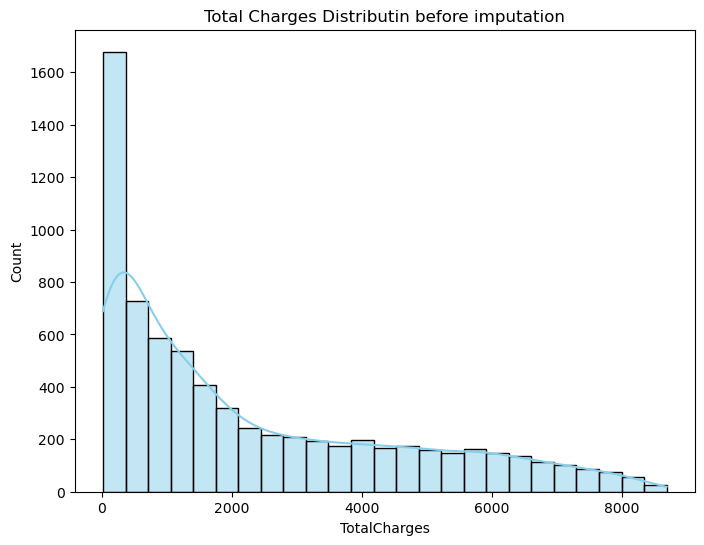

Skewness: 0.961642499724251


In [20]:
plt.figure(figsize=(8,6))
sns.histplot(df['TotalCharges'], kde=True, color='skyblue')
plt.title("Total Charges Distributin before imputation")
plt.show()
print(f'Skewness: {df['TotalCharges'].skew()}')

In [21]:
# missing values index
missing_index = df[df['TotalCharges'].isna()].index

# filling with monthly charges
df.loc[missing_index, 'TotalCharges'] = df.loc[missing_index, 'MonthlyCharges']

### Distribution after Imputation

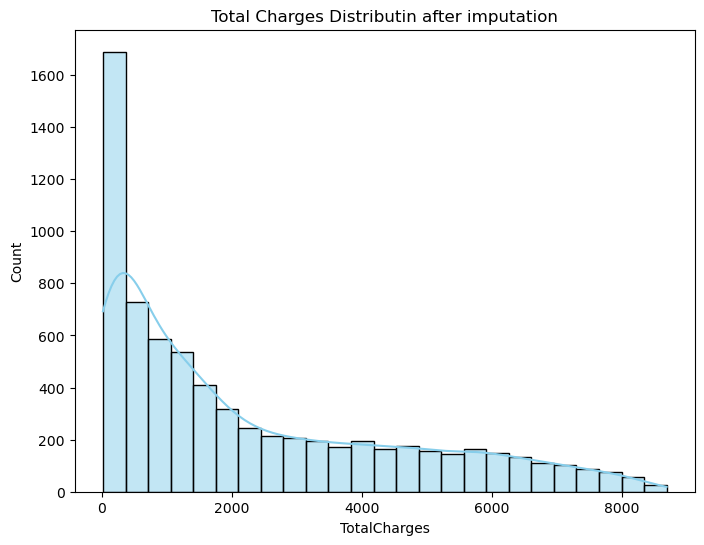

Skewness: 0.9633155974592842


In [23]:
plt.figure(figsize=(8,6))
sns.histplot(df['TotalCharges'], kde=True, color='skyblue')
plt.title("Total Charges Distributin after imputation")
plt.show()
print(f'Skewness: {df['TotalCharges'].skew()}')

## Handling Missing Values in `TotalCharges`

The `TotalCharges` column contained a small number of missing values (~11 rows).  
These missing values all occurred for customers with **tenure = 0**, meaning they had just joined the service.  

Many people impute these missing values with **0**, but this does not align with business logic:
- Even new customers already have a **monthly plan assigned**, reflected in the `MonthlyCharges` column.
- If such a customer churned after just one month, their total cost would realistically equal **one month’s charges**, not zero.

### Imputation Choice
For customers with tenure = 0 and missing `TotalCharges`, I imputed:
$$
\text{TotalCharges} = \text{MonthlyCharges}
$$

This approach ensures consistency between **monthly cost** and **total accumulated charges**, while also reflecting real billing behavior more accurately.

---

### Validation of Imputation
To ensure this imputation was robust:
- I plotted the **histogram with KDE** of `TotalCharges` before and after imputation.  
  > The shapes were **almost identical**, confirming that the imputation did not distort the distribution.
- I compared skewness before vs after imputation:  

| Metric      | Before | After  |
|-------------|--------|--------|
| Skewness    | 0.9616 | 0.9633 |

The negligible change in skewness demonstrates that this imputation is **statistically sound** and does not bias the data.

---

### Conclusion
By imputing `TotalCharges = MonthlyCharges` for tenure = 0 customers:
- The dataset remains consistent with real-world billing practices.
- The distribution of `TotalCharges` remains almost unchanged.
- This provides a **robust and business-justified imputation** method compared to simply filling with zero.

## Categorical Columns Analysis

#### - Let's check number of unique categories in categorical columns.

In [27]:
cat_cols = df.select_dtypes(include='object').drop(columns=['Churn', 'customerID'], axis=1)

In [28]:
for col in cat_cols.columns.to_list():
    print("Unique Categories in ",col)
    display(cat_cols[col].unique())

Unique Categories in  gender


array(['Female', 'Male'], dtype=object)

Unique Categories in  Partner


array(['Yes', 'No'], dtype=object)

Unique Categories in  Dependents


array(['No', 'Yes'], dtype=object)

Unique Categories in  PhoneService


array(['No', 'Yes'], dtype=object)

Unique Categories in  MultipleLines


array(['No phone service', 'No', 'Yes'], dtype=object)

Unique Categories in  InternetService


array(['DSL', 'Fiber optic', 'No'], dtype=object)

Unique Categories in  OnlineSecurity


array(['No', 'Yes', 'No internet service'], dtype=object)

Unique Categories in  OnlineBackup


array(['Yes', 'No', 'No internet service'], dtype=object)

Unique Categories in  DeviceProtection


array(['No', 'Yes', 'No internet service'], dtype=object)

Unique Categories in  TechSupport


array(['No', 'Yes', 'No internet service'], dtype=object)

Unique Categories in  StreamingTV


array(['No', 'Yes', 'No internet service'], dtype=object)

Unique Categories in  StreamingMovies


array(['No', 'Yes', 'No internet service'], dtype=object)

Unique Categories in  Contract


array(['Month-to-month', 'One year', 'Two year'], dtype=object)

Unique Categories in  PaperlessBilling


array(['Yes', 'No'], dtype=object)

Unique Categories in  PaymentMethod


array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

## Observations on Categorical Features

While inspecting categorical columns, I found that some features contain **nested categories** instead of simple Yes/No responses:

1. **Phone Service Features**
   - `MultipleLines` has 3 categories:
     - `Yes` → Customer has multiple lines.  
     - `No` → Customer has only one line.  
     - `No phone service` → Customer has not subscribed to phone service.  

2. **Internet Service Features**
   - The four security-related columns (`OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`)  
   - The two streaming-related columns (`StreamingTV`, `StreamingMovies`)  
   - All contain 3 categories:
     - `Yes` → Customer subscribed to the add-on service.  
     - `No` → Customer has internet but did not subscribe to the add-on service.  
     - `No internet service` → Customer does not have internet, so the add-on is not applicable.  

---

### Why This Matters
- These features are **not purely binary**. The "no service" category acts as a **structural missing value** (meaning the service is not applicable rather than a true “No”).  
- Encoding must carefully preserve this distinction:
  - Collapsing `"No internet service"` into `"No"` would lose important information.  
  - Keeping it as a separate category ensures the model can differentiate between **not applicable** vs **actively declined**.  

---

### Plan for Encoding
- Retain all three categories during one-hot encoding (e.g., `Yes`, `No`, `No internet service`).  
- Alternatively, consider grouping `"No internet service"` into a separate feature flag (e.g., `HasInternet = 0/1`) 

## Summary Statistics

In [31]:
df.describe(include='number')

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.798992
std,0.368612,24.559481,30.090047,2266.730170
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


## Summary Statistics Insight

From the descriptive statistics:

- `tenure` ranges from **0 to 72 months** with a mean of ~32 months.  
- `MonthlyCharges` have a wide spread (18.25–118.75), reflecting different service packages.  
- `TotalCharges` shows a large standard deviation (~2266), consistent with being cumulative over tenure.  
- Cases with `tenure = 0` exist, but overall the distribution of `TotalCharges` remains consistent, with mean and std in line with expectations.  

This confirms the dataset is statistically reasonable after imputation.

## Consistency Between TotalCharges, MonthlyCharges, and Tenure

In general, `TotalCharges` should be approximately equal to:

$$
\text{TotalCharges} \approx \text{MonthlyCharges} \times \text{Tenure}
$$

- This relationship holds well across the dataset, since `TotalCharges` is cumulative over time.  
- The only exception is customers with **tenure = 0**, where I imputed `TotalCharges = MonthlyCharges` instead of 0.  
  - This adjustment reflects real billing logic: even new customers already owe their first month’s charge.  
- As a result, the strict formula does not apply to those few rows, but the imputation remains **business-consistent and robust**.


# EDA(Exploratory Data Analysis)

## Target Variable Analysis

Value Counts:  Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


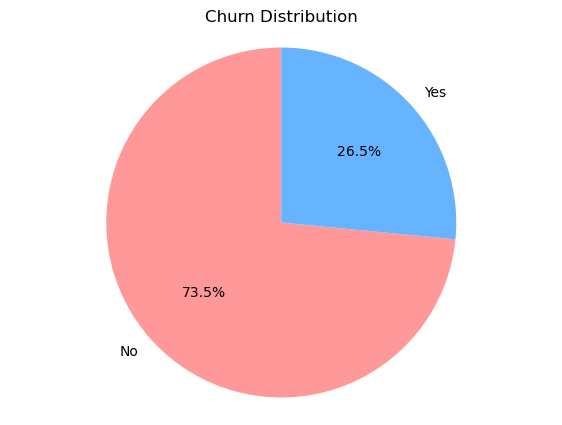

In [36]:
churn_counts = df['Churn'].value_counts()
# Get the labels and sizes for the pie chart
labels = churn_counts.index
sizes = churn_counts.values

# Plotting the pie chart
plt.figure(figsize=(7, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Churn Distribution')
plt.axis('equal')
plt.savefig('churn_pie_chart.png')
print("Value Counts: ", df['Churn'].value_counts(normalize=True))

## Churn Distribution Analysis

The target variable `Churn` was analyzed to understand its distribution. The value counts reveal that 73.46% of customers did not churn (`No`), while 26.54% of customers churned (`Yes`). This distribution is visualized in a pie chart, highlighting the imbalance between the two classes, with a significantly larger proportion of non-churning customers.

## Tenure (Duration Feature)

## Distribution of Tenure

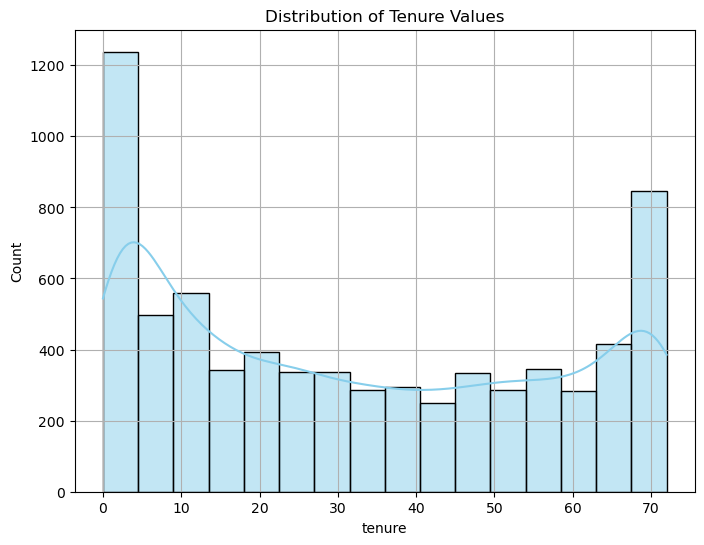

In [40]:
plt.figure(figsize=(8,6))
sns.histplot(df['tenure'], kde=True, color='skyblue')
plt.title("Distribution of Tenure Values")
plt.grid(True)
plt.show()

# Tenure Distribution Analysis

The tenure distribution histogram reveals two prominent peaks. The first peak, between 0 and 5 tenure with over 1200 counts, indicates a large proportion of very new customers. The second peak, around 70 and above tenure with over 800 counts, highlights a significant number of highly loyal customers. The distribution between these peaks appears balanced with no dominant intermediate peaks, suggesting a varied customer tenure profile worth further exploration.

## Categorical Variables Distribution

Value Counts: gender
Male      0.504756
Female    0.495244
Name: proportion, dtype: float64


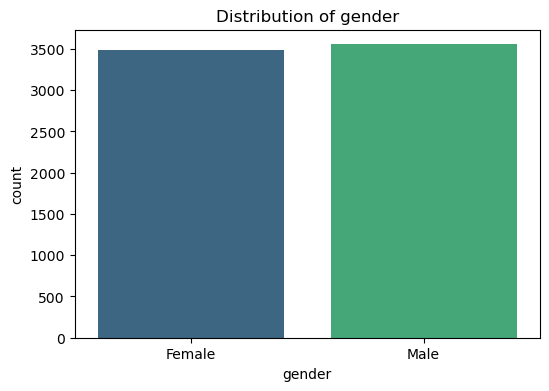

Value Counts: Partner
No     0.516967
Yes    0.483033
Name: proportion, dtype: float64


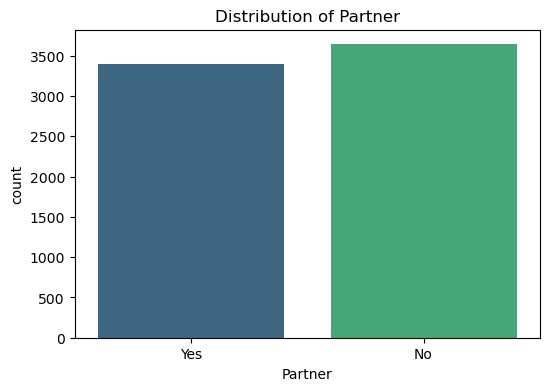

Value Counts: Dependents
No     0.700412
Yes    0.299588
Name: proportion, dtype: float64


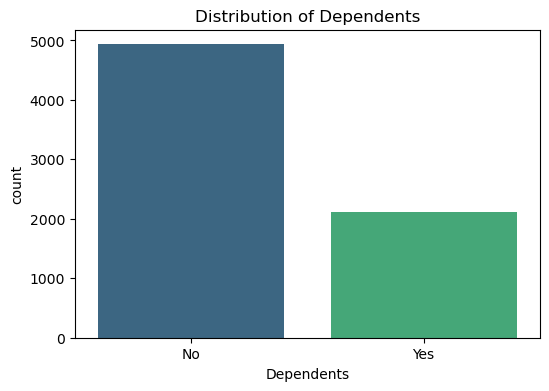

Value Counts: PhoneService
Yes    0.903166
No     0.096834
Name: proportion, dtype: float64


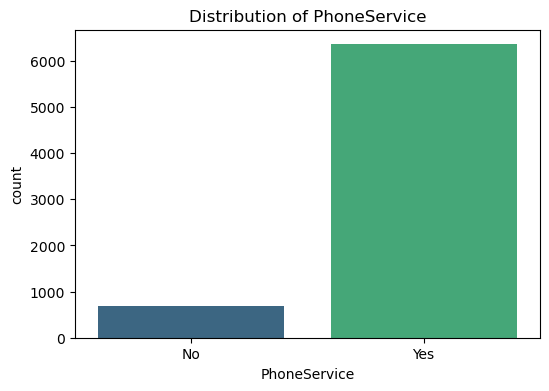

Value Counts: MultipleLines
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: proportion, dtype: float64


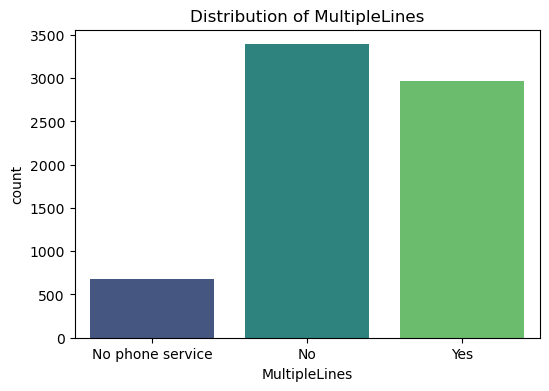

Value Counts: InternetService
Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: proportion, dtype: float64


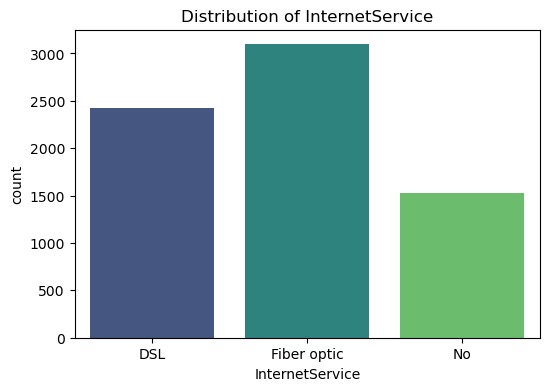

Value Counts: OnlineSecurity
No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: proportion, dtype: float64


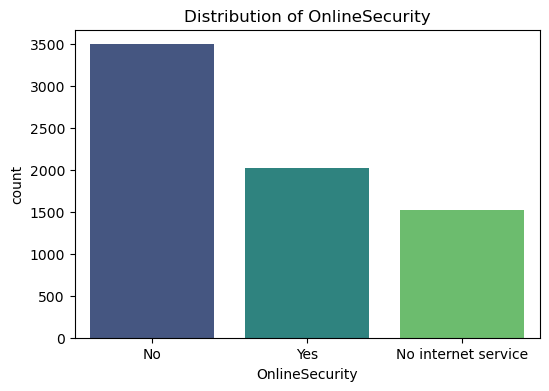

Value Counts: OnlineBackup
No                     0.438450
Yes                    0.344881
No internet service    0.216669
Name: proportion, dtype: float64


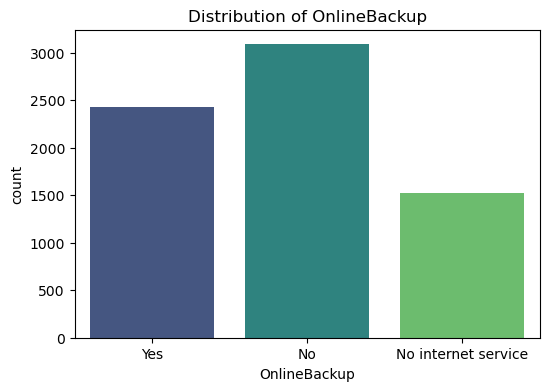

Value Counts: DeviceProtection
No                     0.439443
Yes                    0.343888
No internet service    0.216669
Name: proportion, dtype: float64


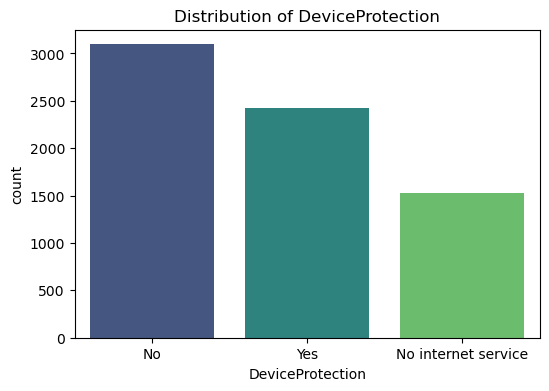

Value Counts: TechSupport
No                     0.493114
Yes                    0.290217
No internet service    0.216669
Name: proportion, dtype: float64


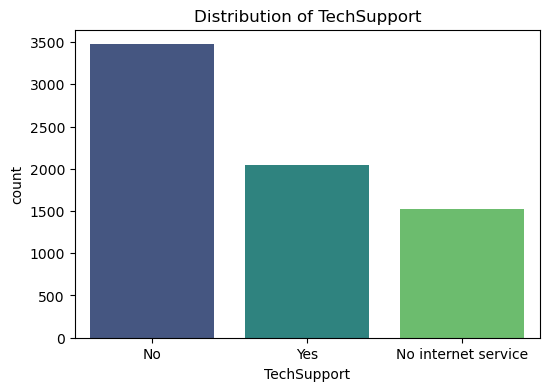

Value Counts: StreamingTV
No                     0.398978
Yes                    0.384353
No internet service    0.216669
Name: proportion, dtype: float64


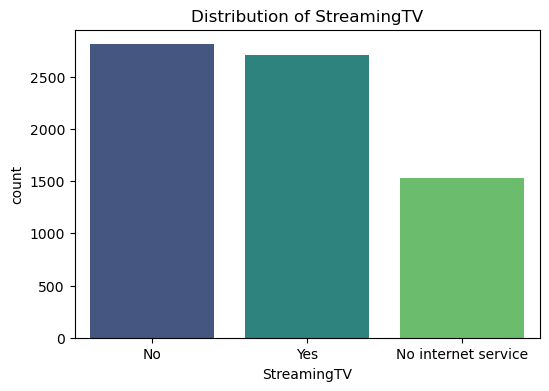

Value Counts: StreamingMovies
No                     0.395428
Yes                    0.387903
No internet service    0.216669
Name: proportion, dtype: float64


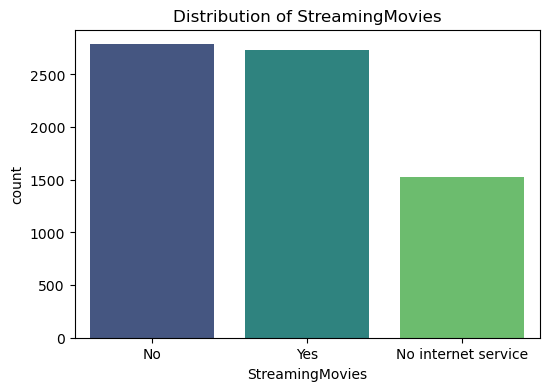

Value Counts: Contract
Month-to-month    0.550192
Two year          0.240664
One year          0.209144
Name: proportion, dtype: float64


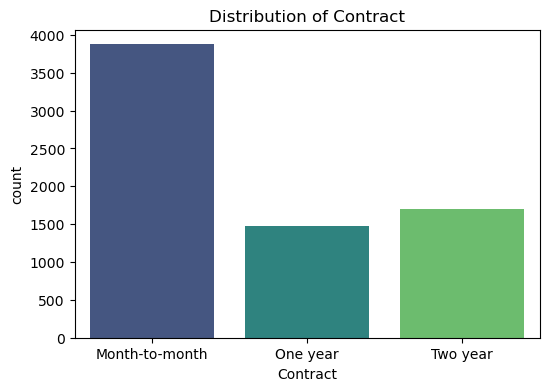

Value Counts: PaperlessBilling
Yes    0.592219
No     0.407781
Name: proportion, dtype: float64


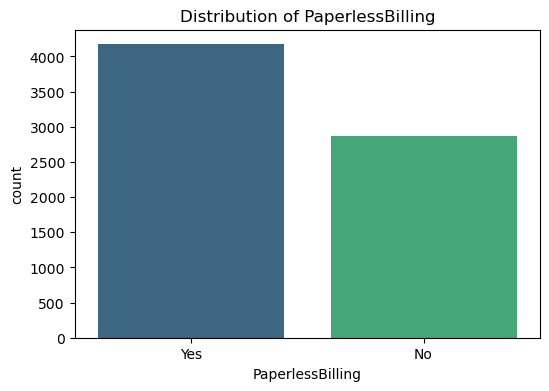

Value Counts: PaymentMethod
Electronic check             0.335794
Mailed check                 0.228880
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Name: proportion, dtype: float64


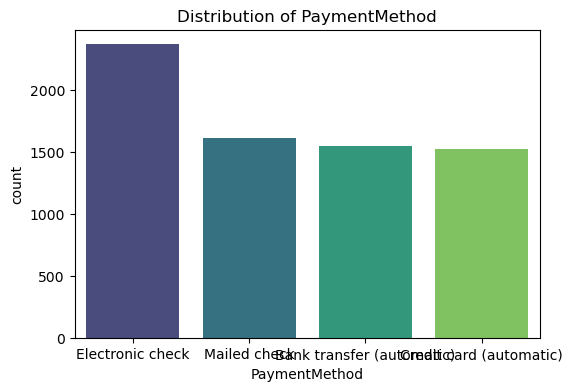

In [43]:
for col in cat_cols.columns.to_list():
    print("Value Counts:", cat_cols[col].value_counts(normalize=True))
    plt.figure(figsize=(6,4))
    sns.countplot(x=cat_cols[col], palette='viridis')
    plt.title(f"Distribution of {col}")
    plt.show()

# Unveiling Customer Demographics: A Deep Dive into Key Variables

## Demographic and Household Insights

### Gender
- The dataset showcases a near-perfect balance with **males at 50.48%** and **females at 49.52%**. This suggests that gender alone is unlikely to be a significant predictor of churn.

### Partners and Dependents
- There is a slight majority of customers without a partner (**51.70%**), but a notable majority without dependents (**70.04%**). This imbalance could be a crucial factor in understanding churn, as family status often influences service needs.

## Service Adoption & Usage Patterns

### Phone and Internet Services
- As expected, **90.32% of customers have phone service**. More interestingly, InternetService reveals a fragmented market: **43.96% rely on Fiber Optic**, a slight majority over DSL (**34.37%**). A significant **21.67% of the customer base does not use internet services at all**.

### Add-On Services

#### Security & Protection
- A key observation is the high number of customers who do not have security and device protection services, such as **OnlineSecurity (49.67%)** and **DeviceProtection (43.94%)**. This is a potential vulnerability and a target for retention strategies.

#### Entertainment
- The distribution for streaming services is relatively balanced between those who have them and those who don't, with **38-39% opting for StreamingTV or StreamingMovies**.

## Contract and Billing Preferences

### Contract Type
- The customer base is heavily skewed towards short-term commitments. A striking **55.02% are on a month-to-month contract**, which is the most vulnerable to churn. In contrast, only **24.07% are on a two-year contract**.

### Paperless Billing
- A majority of customers prefer convenience, with **59.22% opting for paperless billing**.

### Payment Method
- Electronic checks are the most popular payment method, used by **33.58% of the customers**.

## Key Insight for Analysis
- A consistent and critical finding across multiple service columns (**OnlineSecurity**, **OnlineBackup**, **DeviceProtection**, **TechSupport**, **StreamingTV**, **StreamingMovies**) is the shared **"No internet service" category**, representing **21.67% of the customers**. This means that a single group of customers without internet service is affecting the distribution across all these features. This group's unique behavior and churn patterns should be analyzed separately to avoid misinterpretation of the data.

## Distribution of charges

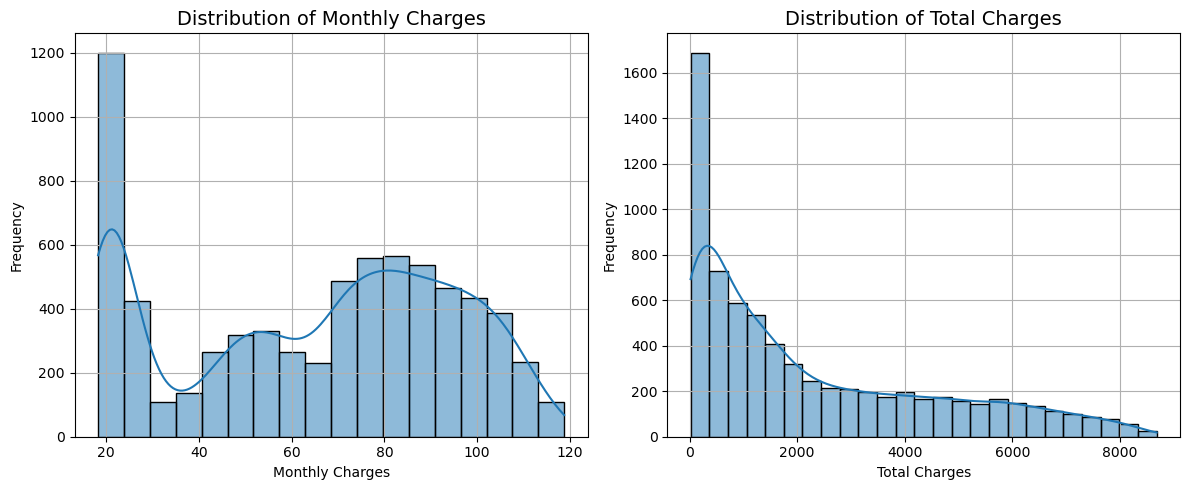

In [46]:
plt.figure(figsize=(12, 5))

# Plot for Monthly Charges
plt.subplot(1, 2, 1)
sns.histplot(x=df['MonthlyCharges'], kde=True)
plt.title("Distribution of Monthly Charges", fontsize=14)
plt.grid(True)
plt.xlabel("Monthly Charges")
plt.ylabel("Frequency")

# Plot for Total Charges
plt.subplot(1, 2, 2)
sns.histplot(x=df['TotalCharges'], kde=True)
plt.title("Distribution of Total Charges", fontsize=14)
plt.grid(True)
plt.xlabel("Total Charges")
plt.ylabel("Frequency")

plt.tight_layout()

plt.show()

# Distribution Insights: Monthly vs. Total Charges

## Monthly Charges
- The distribution of monthly charges is **bimodal**, featuring two distinct peaks, indicating two primary customer groups:
  - A group with **lower monthly charges (around $20-$30)**.
  - A larger group with **higher monthly charges (around $70-$100)**.
- This pattern likely reflects different service plans or customer segments, such as basic phone plans versus high-speed internet and bundled services.

## Total Charges
- The distribution of total charges is **highly right-skewed**, with most customers showing low total charges and a long tail extending to very high values.
- This is typical for tenure-related data, where new customers have low total charges, while long-term customers with high monthly fees accumulate significantly higher total charges.

## Correlation

In [49]:
corr = df.corr(numeric_only=True)
corr

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.016567,0.220173,0.102997
tenure,0.016567,1.000000,0.247900,0.826164
MonthlyCharges,0.220173,0.247900,1.000000,0.651182
TotalCharges,0.102997,0.826164,0.651182,1.000000


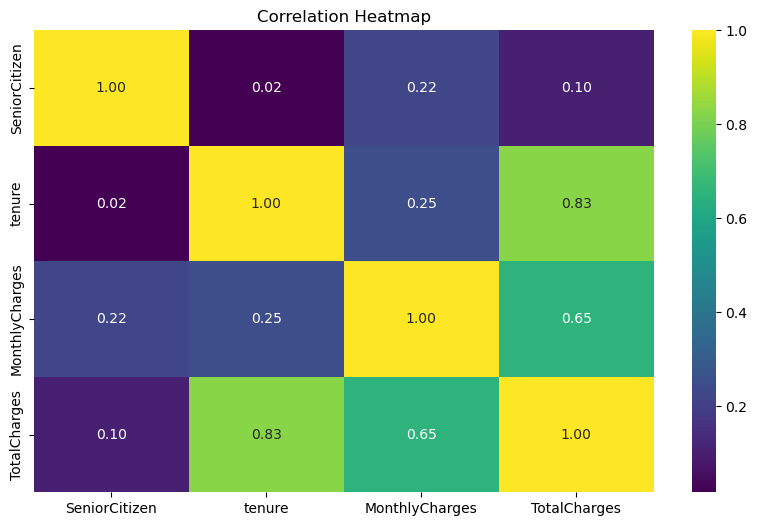

In [50]:
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='viridis')
plt.title("Correlation Heatmap")
plt.show()

# Insights from Numeric Variable Correlation

The correlation matrix reveals strong relationships between key numeric variables in the dataset.

## Key Relationships

### Tenure & Total Charges (0.83)
- **Very strong positive correlation** between tenure and TotalCharges.
- This makes logical sense, as the longer a customer stays, the more their total charges will accumulate.
- This is the **strongest relationship** in the matrix.

### Monthly & Total Charges (0.65)
- **Strong positive correlation** between MonthlyCharges and TotalCharges.
- This is expected, as customers with higher monthly bills will naturally have higher total charges over time.

### Monthly & Tenure (0.25)
- **Weakly positive** relationship between MonthlyCharges and tenure.
- While there is some connection, it's not a strong one, suggesting that high monthly charges don't necessarily correlate with longer customer loyalty.

## Minimal Correlation

### Senior Citizen
- The SeniorCitizen variable has **very low correlations** with tenure, MonthlyCharges, and TotalCharges (all below 0.25).
- This indicates that being a senior citizen has **little direct linear relationship** with how long a customer stays or how much they pay.

## Categorical Variables Distribution by Churn

Churn Rate by gender


Churn,No,Yes
gender,,
Female,0.36192,0.133324
Male,0.37271,0.132046


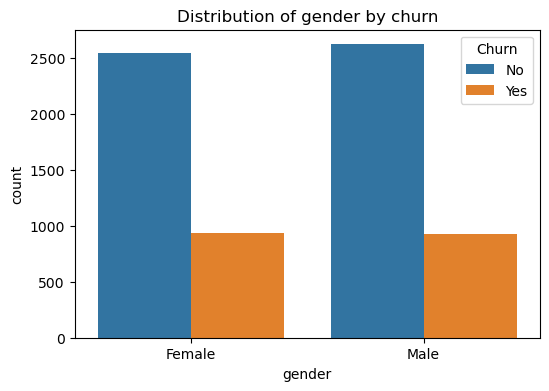

Churn Rate by Partner


Churn,No,Yes
Partner,,
No,0.346585,0.170382
Yes,0.388045,0.094988


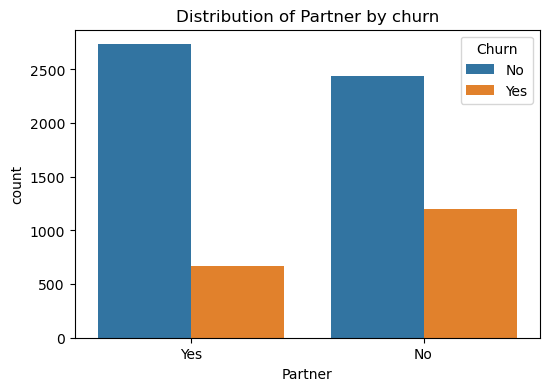

Churn Rate by Dependents


Churn,No,Yes
Dependents,,
No,0.481329,0.219083
Yes,0.253301,0.046287


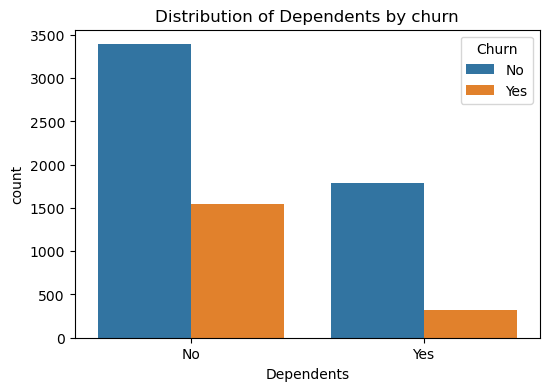

Churn Rate by PhoneService


Churn,No,Yes
PhoneService,,
No,0.072696,0.024137
Yes,0.661934,0.241232


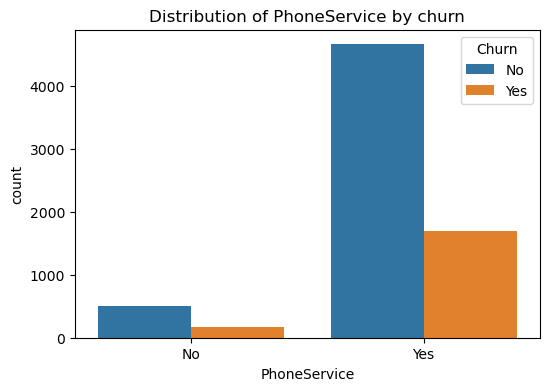

Churn Rate by MultipleLines


Churn,No,Yes
MultipleLines,,
No,0.360784,0.120545
No phone service,0.072696,0.024137
Yes,0.301150,0.120687


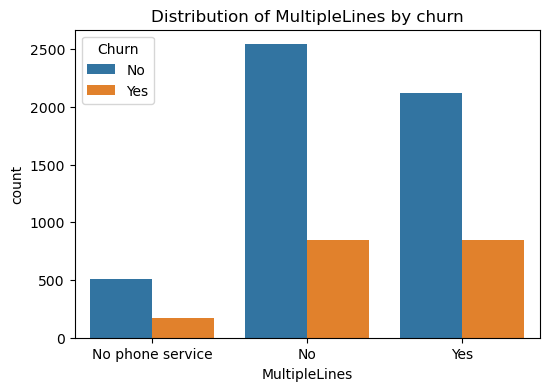

Churn Rate by InternetService


Churn,No,Yes
InternetService,,
DSL,0.278574,0.065171
Fiber optic,0.255431,0.184154
No,0.200625,0.016044


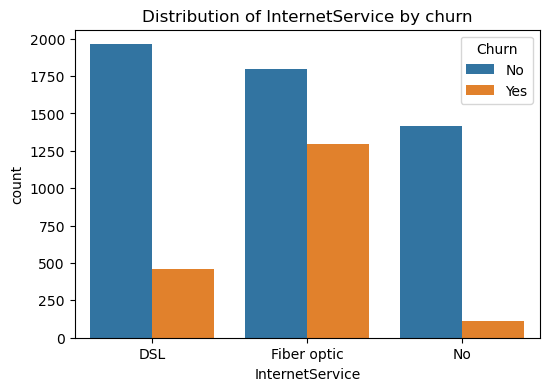

Churn Rate by OnlineSecurity


Churn,No,Yes
OnlineSecurity,,
No,0.289223,0.207440
No internet service,0.200625,0.016044
Yes,0.244782,0.041886


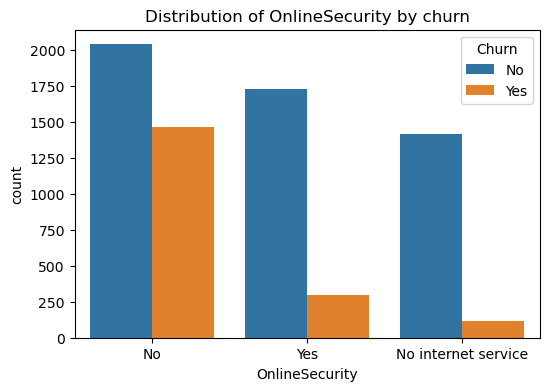

Churn Rate by OnlineBackup


Churn,No,Yes
OnlineBackup,,
No,0.263382,0.175067
No internet service,0.200625,0.016044
Yes,0.270623,0.074258


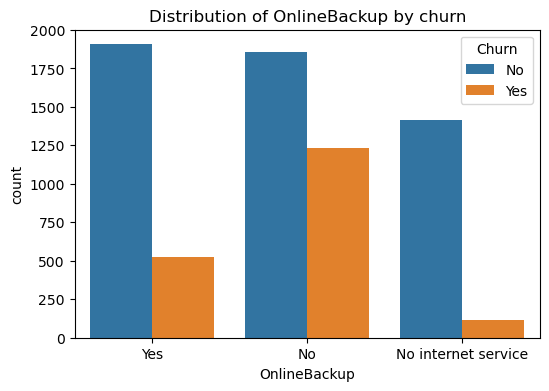

Churn Rate by DeviceProtection


Churn,No,Yes
DeviceProtection,,
No,0.267500,0.171944
No internet service,0.200625,0.016044
Yes,0.266506,0.077382


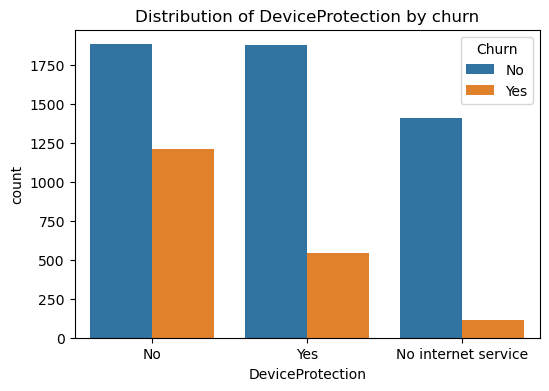

Churn Rate by TechSupport


Churn,No,Yes
TechSupport,,
No,0.287803,0.205310
No internet service,0.200625,0.016044
Yes,0.246202,0.044015


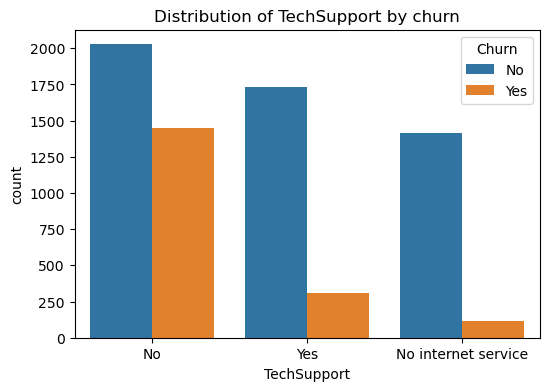

Churn Rate by StreamingTV


Churn,No,Yes
StreamingTV,,
No,0.265228,0.133750
No internet service,0.200625,0.016044
Yes,0.268778,0.115576


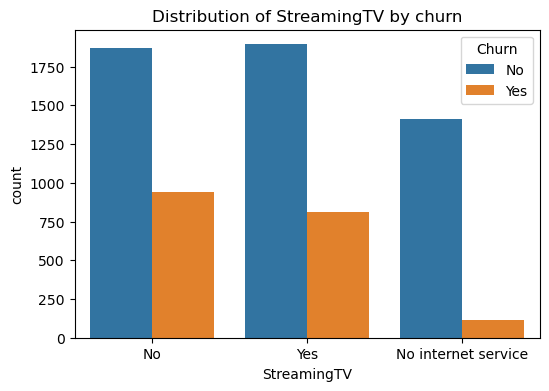

Churn Rate by StreamingMovies


Churn,No,Yes
StreamingMovies,,
No,0.262246,0.133182
No internet service,0.200625,0.016044
Yes,0.271759,0.116144


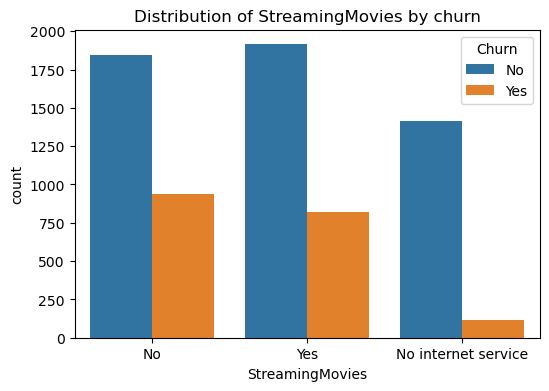

Churn Rate by Contract


Churn,No,Yes
Contract,,
Month-to-month,0.315207,0.234985
One year,0.185574,0.023570
Two year,0.233849,0.006815


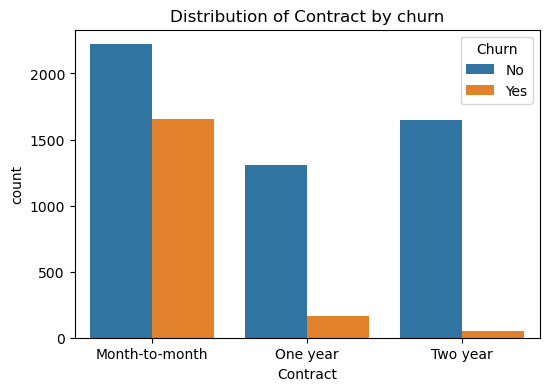

Churn Rate by PaperlessBilling


Churn,No,Yes
PaperlessBilling,,
No,0.34119,0.066591
Yes,0.39344,0.198779


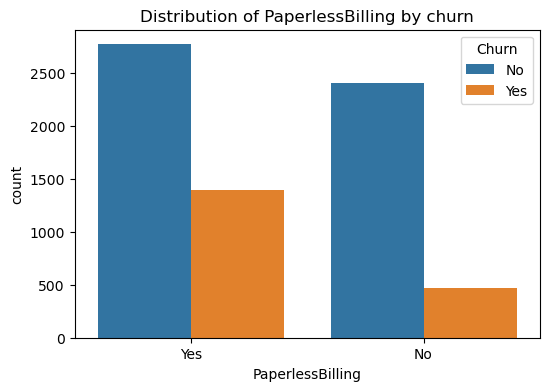

In [53]:
for col in cat_cols.columns.to_list()[:-1]:
    print(f"Churn Rate by {col}")
    table = pd.crosstab(cat_cols[col], df['Churn'], normalize=True)
    display(table)
    plt.figure(figsize=(6,4))
    sns.countplot(x=cat_cols[col], hue=df['Churn'])
    plt.title(f"Distribution of {col} by churn")
    plt.show()

Churn Rate by Payment Method


Churn,No,Yes
PaymentMethod,,
Bank transfer (automatic),0.182593,0.036632
Credit card (automatic),0.183161,0.032941
Electronic check,0.183729,0.152066
Mailed check,0.185148,0.043731


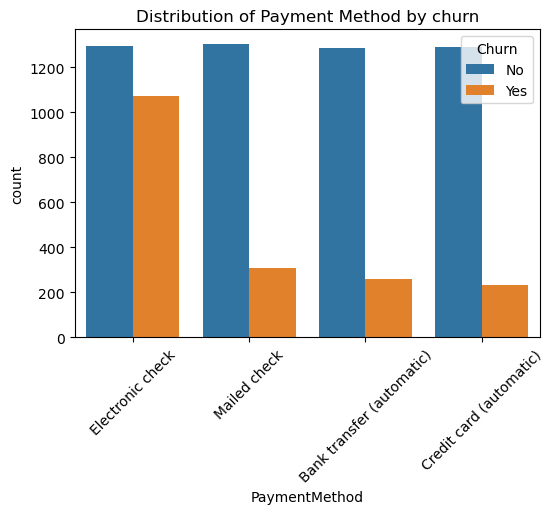

In [54]:
print("Churn Rate by Payment Method")
table = pd.crosstab(cat_cols['PaymentMethod'], df['Churn'], normalize=True)
display(table)
plt.figure(figsize=(6,4))
sns.countplot(x=cat_cols['PaymentMethod'], hue=df['Churn'])
plt.title("Distribution of Payment Method by churn")
plt.xticks(rotation=45)
plt.show()

# A Deep Dive into Categorical Variables

This analysis explores the relationship between various categorical features and customer churn, revealing key patterns and potential drivers.

## 1. Demographics & Household Factors

### Gender
- **Churn Insight**: No significant predictive power for churn.
- **Details**: Churn rates are nearly identical at **13.2% for males** and **13.3% for females**, suggesting this variable may not be a strong feature for a predictive model.

### Partner
- **Churn Insight**: Higher churn among those without a partner.
- **Details**: Customers without a partner churn at **17.0%**, compared to **9.5%** with a partner. This may indicate greater flexibility in switching providers for individuals without household obligations.

### Dependents
- **Churn Insight**: Strong influence from dependents on churn.
- **Details**: Customers without dependents churn at **21.9%**, while those with dependents churn at **4.6%**. This highlights that family responsibilities may prioritize stability and reduce churn.

## 2. Service-Related Features

### Phone Service
- **Churn Insight**: Strong correlation with churn.
- **Details**: Customers with phone service churn at **24.1%**, compared to **2.4%** without. Issues with phone service or costs may drive churn.

### Multiple Lines
- **Churn Insight**: No strong correlation with churn.
- **Details**: Churn rates are similar at **12.1% with multiple lines** and **12.0% without**, indicating limited predictive value.

### Internet Service
- **Churn Insight**: Significant variation by service type.
- **Details**: Fiber Optic users churn at **18.4%**, far higher than DSL (**6.5%**) or no internet service (**1.6%**). Poor Fiber Optic experience (quality or pricing) may be a key churn driver.

## 3. Add-On Services

### Security & Protection
- **Churn Insight**: Lack of services increases churn.
- **Details**: Customers without **Online Security (20.7%)** or **Tech Support (20.5%)** churn more than those with these services, suggesting they enhance loyalty.

### Online Backup & Device Protection
- **Churn Insight**: Similar pattern to security services.
- **Details**: Churn rates are higher without **Online Backup (17.5%)** or **Device Protection (17.2%)**, reinforcing that protected customers are more likely to stay.

### Streaming Services
- **Churn Insight**: Minimal impact on reducing churn.
- **Details**: Churn rates are **11.6% with StreamingMovies** and **11.5% with StreamingTV**, slightly higher than **13.3%** and **13.4%** without, indicating other factors may dominate.

## 4. Billing & Contract Features

### Contract
- **Churn Insight**: Strongest predictor of churn.
- **Details**: Month-to-month contracts have a **23.5% churn rate**, dropping to **2.4% for one-year** and **0.7% for two-year** contracts. Long-term contracts significantly boost retention.

### Paperless Billing
- **Churn Insight**: Higher churn with paperless billing.
- **Details**: Customers with paperless billing churn at **19.9%**, compared to **6.7%** without, suggesting convenience alone may not ensure loyalty.

### Payment Method
- **Churn Insight**: Payment method influences churn.
- **Details**: Electronic checks show **15.2% churn**, while automated payments (credit card or bank transfer) have very low rates, possibly due to convenience or security concerns.

## 5. Analysis Refinement
- **Key Finding**: The "No internet service" group (with a **1.6% churn rate**) consistently appears across internet-related add-on features.
- **Action**: This distinct segment should be analyzed separately to avoid skewing insights for internet-using customers, as their needs and behaviors differ significantly.

## Tenure Distribution by Churn

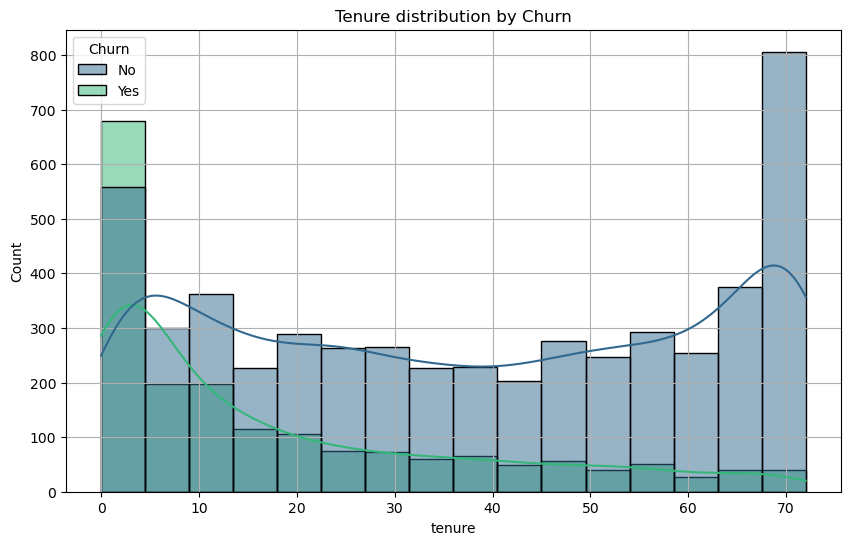

In [57]:
plt.figure(figsize=(10,6))
sns.histplot(x=df['tenure'], hue=df['Churn'], kde=True, palette='viridis')
plt.title("Tenure distribution by Churn")
plt.grid(True)
plt.show()

# Insights from Tenure vs. Churn Distribution

## Initial High Churn
- The distribution reveals a **very high churn rate for new customers with a tenure of 0-5 months**. This is a common pattern in subscription-based businesses, often due to initial dissatisfaction or lack of commitment.

## Declining Churn with Increasing Tenure
- As tenure increases, the churn rate **monotonically decreases**. This supports the intuitive notion that customers with longer tenure are more loyal and less likely to leave the service.

## Peak Customer Loyalty
- The plot highlights a **significant peak in non-churning customers at the highest tenure ranges (around 70 months)**. This group represents the most loyal customers, reinforcing the strong link between longevity and retention.

## Key Takeaway
- The analysis confirms that **tenure is a strong predictor of churn**, with a clear negative correlation. The longer a customer stays, the lower their risk of churning. This insight is valuable for developing retention strategies targeted at new customers.

## Monthly Charges by Churn

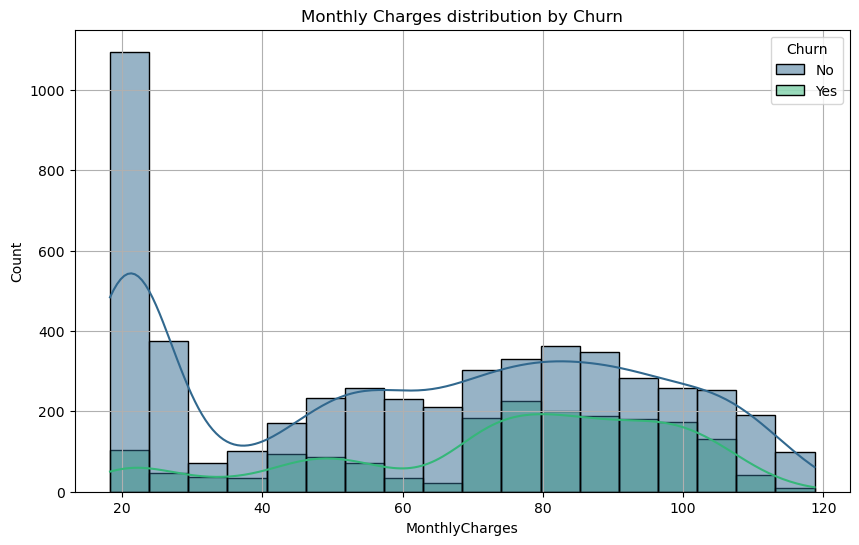

In [71]:
plt.figure(figsize=(10,6))
sns.histplot(x=df['MonthlyCharges'], hue=df['Churn'], kde=True, palette='viridis')
plt.title("Monthly Charges distribution by Churn")
plt.grid(True)
plt.show()

# Monthly Charges vs. Churn: Key Insights

## Low-Cost Customers are Loyal
- The plot shows a **significant majority of non-churning customers concentrated in the lowest charge bracket (around $20)**. This suggests that basic, low-cost service plans have a **high retention rate**.

## High-Cost Customers are at Risk
- A **distinct pattern of churn emerges among customers with higher monthly charges**. Churn is consistently high from the mid-range to the high-end of the price scale, peaking around **$70-$100**. This implies that while these customers may be valuable, they are **more sensitive to perceived value and service quality**, increasing their likelihood of churning.

## Summary
- The data suggests a **two-tiered churn dynamic**: low-cost customers are highly loyal, while high-cost customers pose a significant churn risk. This is a **critical finding for developing targeted retention strategies**.

## Total charges by Churn

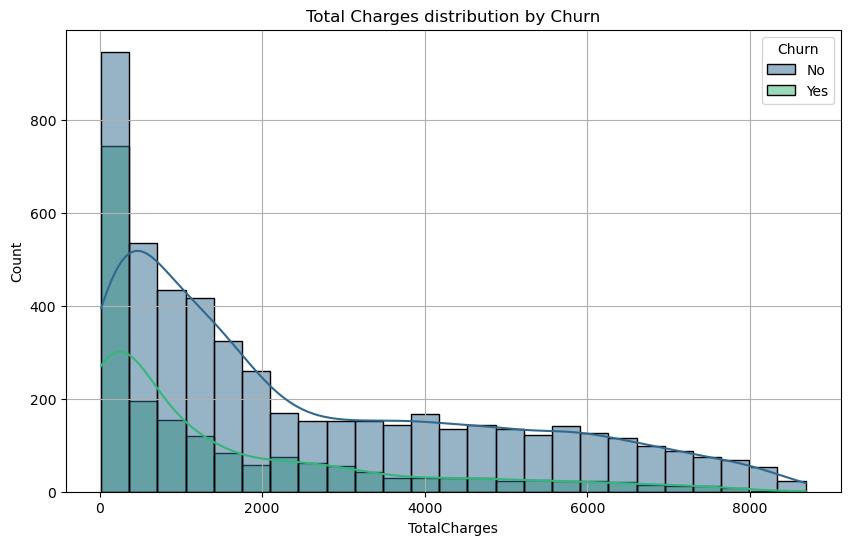

In [74]:
plt.figure(figsize=(10,6))
sns.histplot(x=df['TotalCharges'], hue=df['Churn'], kde=True, palette='viridis')
plt.title("Total Charges distribution by Churn")
plt.grid(True)
plt.show()

# Total Charges vs. Churn: Key Insights

## New Customers are a Churn Risk
- The plot shows a **significant concentration of both churned and loyal customers at the lowest end of the TotalCharges scale**. This high frequency for both groups at low total charges is a direct result of churn occurring among new customers.

## Loyalty Grows with Total Spend
- As TotalCharges increase, the number of churned customers **monotonically decreases**. This indicates that customers with higher accumulated charges—due to long tenure or high monthly payments—are **significantly more loyal** and have a **much lower risk of churning**.

## Churn is a Short-Term Event
- The high churn rate at low total charges confirms that churn is **primarily a short-term phenomenon**. This reinforces the finding that customer loyalty builds over time, making churn a key concern for new customer acquisition and early retention strategies.

## **Churn Trend over Tenure**

### Mapping Churn into Numeric

In [84]:
df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

In [85]:
# Aggregating data to calculate churn rate per tenure month
churn_rate_by_tenure = df.groupby('tenure')['Churn'].agg(
    churn_rate='mean',
    customer_count='count'
).reset_index()

# Plotting the line chart with a trendline
fig = px.line(
    data_frame=churn_rate_by_tenure,
    x='tenure',
    y='churn_rate',
    labels={'tenure': 'Tenure in Months', 'churn_rate': 'Churn Rate (%)'},
    title='Churn Rate Trend Over Customer Tenure',
    hover_data={'customer_count': True},
)

fig.update_yaxes(tickformat=".1%")

fig.show()

# Churn Rate Trend Over Customer Tenure

The line plot clearly illustrates the **inverse relationship between customer tenure and churn rate**.

## Early Customer Vulnerability
- The churn rate is at its **highest point for new customers**, peaking at **over 60% in the first month**. This steep initial drop indicates that new customers are a **high churn risk**.

## Declining Risk with Time
- As customer tenure increases, the churn rate **monotonically decreases**, showing a **consistent decline with each passing month**. This confirms that customer loyalty builds over time.

## Retention is Key for New Customers
- The trend strongly suggests that the **most critical period for customer retention is within the first six months of tenure**, where the churn rate drops most sharply.

## **Churn Trend over Monthly Charges**

In [89]:
# Aggregating data to calculate churn rate per monthly charge amount

churn_rate_by_mc = df.groupby(df['MonthlyCharges'].round(0))['Churn'].agg(
    churn_rate='mean',
    customer_count='count'
).reset_index()

fig = px.line(
    data_frame=churn_rate_by_mc,
    x='MonthlyCharges',
    y='churn_rate',
    labels={'monthlycharges': 'Monthly Charges ($)', 'churn_rate': 'Churn Rate (%)'},
    title='Churn Rate Trend Over Monthly Charges',
    hover_data={'customer_count': True},
)

fig.update_yaxes(tickformat=".1%")

fig.show()

# Churn Rate vs. Monthly Charges: A Volatile Trend

The plot shows **no clear linear relationship between monthly charges and churn rate**. Instead, the trend is **highly volatile and complex**.

## High Volatility
- The churn rate **fluctuates significantly across the entire range of monthly charges**. This lack of a smooth, predictable curve indicates that churn is not solely driven by a customer's monthly bill.

## Distinct Churn Clusters
- While there isn't a simple pattern, churn rates are **particularly high in specific price ranges**, such as the **$40-$50 range** and **consistently from $70-$100**.

## Low Churn Pockets
- There are **distinct pockets of low churn**, particularly in the **mid-range ($60-$70)** and at the **very highest monthly charge points**. This suggests that customers in these brackets may be receiving a **high perceived value for their cost**, reducing their likelihood to churn.

## Key Takeaway
- This trend highlights that churn is likely driven by a **combination of factors beyond just price**, such as service value, plan type, and specific customer needs at different price points.

# Churn by Monthly Charges and Tenure (Size Represent Total Charges)

In [92]:
# Creating the scatter plot
fig = px.scatter(
    data_frame=df,
    x='tenure',
    y='MonthlyCharges',
    color='Churn',
    size='TotalCharges',
    title='Churn by Monthly Charges and Tenure (Size by Total Charges)',
    labels={
        'tenure': 'Tenure in Months',
        'monthlycharges': 'Monthly Charges ($)',
        'totalcharges': 'Total Charges ($)'
    },
    hover_data=['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'],
    size_max=40,
)

fig.show()

# Multi-Dimensional Analysis: Churn by Charges and Tenure

This bubble chart effectively combines four key variables to provide a **comprehensive view of churn behavior**. The visualization confirms and expands upon previous findings.

## Key Insights

### Tenure is the Primary Driver
- The most striking pattern is that **churn (yellow dots)** is heavily concentrated among customers with **low tenure (0-20 months)**.
- As tenure increases beyond this period, the proportion of churned customers **drops dramatically**, confirming that customer loyalty strengthens over time.

### Total Charges Indicate Loyalty
- Since bubble size represents **TotalCharges**, the plot shows that **large bubbles are almost exclusively non-churning (blue)**.
- This is a direct result of long-tenured customers accumulating high total charges, further highlighting the **strong link between longevity and retention**.

### Monthly Charges and Early Churn
- While churn is present across all monthly charge brackets, it is **particularly evident at higher monthly charges for customers with low tenure**.
- This indicates that dissatisfaction with **perceived value or service quality for high-cost plans** may be a key factor in early-stage churn.

## Chi2 on Gender

In [95]:
# Create a contingency table
contingency_table = pd.crosstab(df['gender'], df['Churn'])
print("Contingency Table:")
print(contingency_table)

# Perform the Chi-Squared Test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Squared Statistic:", chi2_stat)
print("P-value:", p_value)

# Interpret the result
if p_value < 0.05:
    print("\nResult: There is a significant association between Gender and Churn.")
else:
    print("\nResult: There is no significant association between Gender and Churn.")

Contingency Table:
Churn      0    1
gender           
Female  2549  939
Male    2625  930

Chi-Squared Statistic: 0.4840828822091383
P-value: 0.48657873605618596

Result: There is no significant association between Gender and Churn.


# Insights from Chi-Squared Test: Gender vs. Churn

The chi-squared test yielded a **high p-value (0.487)**, well above the conventional significance level of **0.05**. This result indicates:

## No Statistical Association
- There is **no statistically significant relationship** between a customer's gender and their churn status.

## Feature Unimportance
- The observed minor differences in churn rates between male and female customers are **likely due to random chance**, not a true pattern.

## Model Simplification
- The **gender column can be considered unimportant** for building a predictive model, as it provides **little to no information** about a customer's likelihood to churn.

# Chi2 on Phone Service
- Above, I noticed that there is significant difference in churn rate of customer with phone service and without.
- But, if i check for total percentage then it will be the very identical and that's why chi2 is showing no association.

In [135]:
# Create a contingency table
contingency_table = pd.crosstab(df['PhoneService'], df['Churn'])
print("Contingency Table:")
print(contingency_table)

# Perform the Chi-Squared Test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("\nChi-Squared Statistic:", chi2_stat)
print("P-value:", p_value)

# Interpret the result
if p_value < 0.05:
    print("\nResult: There is a significant association between Phone Service and Churn.")
else:
    print("\nResult: There is no significant association between Phone Service and Churn.")

Contingency Table:
Churn            0     1
PhoneService            
No             512   170
Yes           4662  1699

Chi-Squared Statistic: 0.9150329892546948
P-value: 0.3387825358066928

Result: There is no significant association between Phone Service and Churn.


# Phone Service vs. Churn Analysis

## Contingency Table
- **Churn 0, PhoneService No**: 512
- **Churn 1, PhoneService No**: 170
- **Churn 0, PhoneService Yes**: 4662
- **Churn 1, PhoneService Yes**: 1699

## Chi-Squared Test Results
- **Chi-Squared Statistic**: 0.9150
- **P-value**: 0.3388

## Conclusion
- There is **no significant association** between Phone Service and Churn, supporting the decision to drop this feature.

## Binning Tenure into Buckets

## Customer Segmentation by Tenure

To gain deeper insights into customer behavior, I've segmented the tenure column into four distinct groups. This allows me to analyze churn and other metrics across different stages of the customer lifecycle.

## New Customers
- **0-6 Months**

## Established Customers
- **7-24 Months**

## Loyal Customers
- **25-48 Months**

## Long-Term Customers
- **49+ Months**

In [104]:
# Define the bin edges and labels
bins = [-float('inf'), 6, 24, 48, float("inf")]  
labels = ['0-6 months', '7-24 months', '25-48 months', '49-72 months']

df['tenure_group'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=True)

## Distribution of Tenure Buckets Column

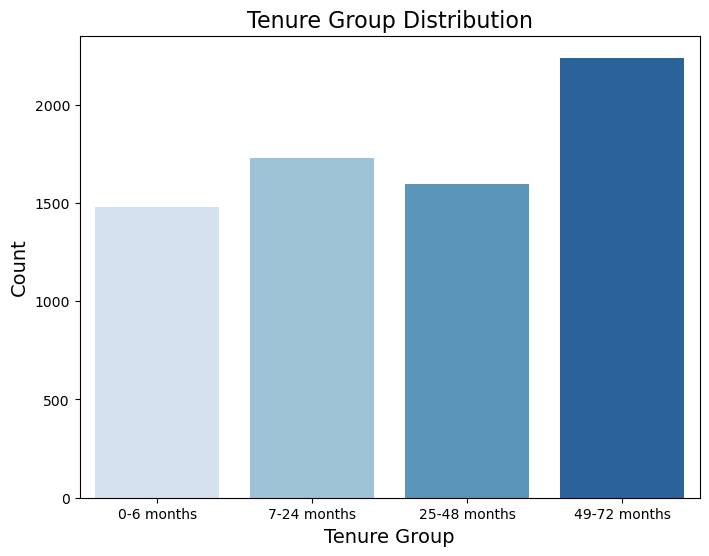

In [108]:
plt.figure(figsize=(8,6))
sns.countplot(x=df['tenure_group'], palette='Blues')
plt.title("Tenure Group Distribution", fontsize=16)
plt.xlabel("Tenure Group", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

# Customer Retention Insights from Tenure Groups Distribution

The bar chart reveals a **positive trend in customer retention** by showing a favorable distribution across the tenure groups.

## Largest Customer Base is Long-Term
- The most significant insight is that the **largest customer segment falls within the 49-72 month tenure group**. This indicates **strong long-term customer loyalty** and successful retention efforts.

## Healthy Distribution
- While the **49-72 months group is the largest**, the other segments (**0-6, 7-24, and 25-48 months**) also have a **healthy and substantial number of customers**. This suggests a **good customer base across all stages of their lifecycle**.

### Missing Values Check

In [117]:
df['tenure_group'].isna().sum()

0

## Remaining EDA Before Survival Analysis

I have already explored the data through:
- Target variable distribution (Churn counts).
- Tenure distribution and its relationship with churn.
- Monthly and total charges distributions, both overall and by churn.
- Churn trends over tenure and monthly charges.
- Scatter plots (MonthlyCharges vs Tenure, size by TotalCharges).
- Chi-square tests on categorical variables (e.g., `gender` → no association → candidate for removal).
- Creation of tenure group feature and barplots for churn across groups.

### Next EDA Steps
Before moving to survival analysis, I will finalize EDA with:
1. **Segment-wise Analysis**
   - Check churn rates across different tenure groups for specific segments (e.g., Fiber Optic vs DSL vs No internet users).
   - Similar segment analysis for contract types, payment methods, etc.

2. **Feature Redundancy & Importance**
   - Variance Inflation Factor (VIF) to identify multicollinearity (e.g., `TotalCharges` vs `MonthlyCharges × Tenure`).
   - Mutual Information (MI) to check categorical feature importance and drop very low-informative features.

---

### Goal
These additional steps will ensure:
- The most relevant features are retained.  
- Redundant or non-informative features are removed.  
- Segment-specific churn behaviors are clearly understood.  

Once this analysis is complete, I will proceed to **survival analysis** starting with Kaplan-Meier curves and Cox Proportional Hazards models.

## Churn vs Tenure Group Analysis

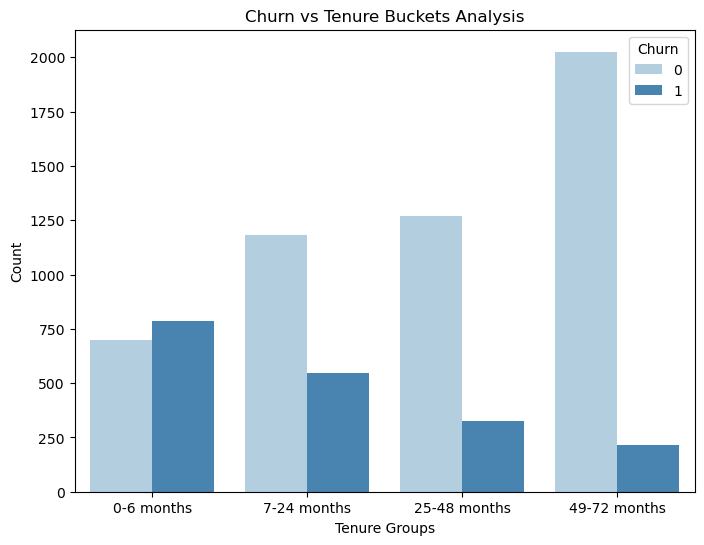

In [123]:
plt.figure(figsize=(8,6))
sns.countplot(data=df ,x=df['tenure_group'], palette='Blues', hue='Churn')
plt.title("Churn vs Tenure Buckets Analysis")
plt.xlabel("Tenure Groups")
plt.ylabel("Count")
plt.show()

# Churn Rate by Tenure Group

## Highest Churn Risk
- The **'0-6 months' group has the highest churn rate by a significant margin**. This is the only tenure segment where the number of churned customers exceeds the number of retained customers, confirming that the new customer phase is the **most critical for retention**.

## Monotonic Decrease
- A **sharp, monotonic decline in churn** is evident with each successive tenure group. The proportion of churned customers drops dramatically from **'0-6 months' to '7-24 months'** and continues to fall, becoming **almost negligible for the '49-72 months' segment**.

## Loyalty Builds Over Time
- The visualization powerfully illustrates that **customer loyalty is a function of time**. The longer a customer stays, the **lower their risk of churning**.

## Dropping `gender` and `Phone Service`

In [142]:
cols_to_drop = ['gender', 'PhoneService']
df.drop(columns=cols_to_drop, axis=1, inplace=True)
## Data preview
df.head(3)

,customerID,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,7590-VHVEG,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-6 months
1,5575-GNVDE,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,25-48 months
2,3668-QPYBK,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-6 months


## VIF on numeric features

In [149]:
numerical_df = df[['tenure','MonthlyCharges','TotalCharges']].copy()
## adding constant as required by VIF
numerical_df = add_constant(numerical_df)

vif_data = pd.DataFrame()
vif_data['features'] = numerical_df.columns
## Calculating VIF for each feature
vif_data['VIF'] = [variance_inflation_factor(numerical_df.values, i) for i in range(len(numerical_df.columns))]
vif_data.round(2)

,features,VIF
0,const,14.90
1,tenure,5.84
2,MonthlyCharges,3.22
3,TotalCharges,9.51


# Insights from VIF Analysis

## Multicollinearity Identified
- The **Variance Inflation Factor (VIF) for TotalCharges is 9.51**, well above the common threshold of 5. This indicates a **high correlation** with other predictor variables, specifically tenure and MonthlyCharges.

## Feature Redundancy
- The high VIF confirms that **TotalCharges is essentially a linear combination of tenure and MonthlyCharges** (as it accumulates over time). Including all three variables can lead to **instability, unreliable coefficient estimates, and reduced interpretability**.

## Modeling Decision
- To avoid these issues, **TotalCharges should be removed from the model**. Its information is already captured by tenure and MonthlyCharges, improving the model's **stability and performance**.

## Dropping `Total Charges`

In [165]:
df.drop('TotalCharges', axis=1, inplace=True)

## Mutual Information Ranking

In [186]:
numerical_features = df.select_dtypes(include='number').columns.drop('Churn')
categorical_features = df.select_dtypes(include='object').columns.drop('customerID')

# Calculating MI for numerical features vs. churn
mi_numerical = mutual_info_classif(df[numerical_features], df['Churn'], random_state=42)
mi_series_numeric = pd.Series(mi_numerical, numerical_features)

# Calculate MI for categorical features vs. churn
mi_categorical = [mutual_info_score(df[col], df['Churn']) for col in categorical_features]
mi_categorical_series = pd.Series(mi_categorical, index=categorical_features)
## Combining Results

mi_series_combined = pd.concat([mi_series_numeric, mi_categorical_series]).sort_values(ascending=False)
print("Combined Mutual Information Scores:")
print(mi_series_combined)

Combined Mutual Information Scores:
Contract            0.098453
tenure              0.081688
OnlineSecurity      0.064677
TechSupport         0.063021
InternetService     0.055574
OnlineBackup        0.046792
MonthlyCharges      0.045601
PaymentMethod       0.044519
DeviceProtection    0.043917
StreamingMovies     0.032001
StreamingTV         0.031908
PaperlessBilling    0.019194
Dependents          0.014467
Partner             0.011454
SeniorCitizen       0.011413
MultipleLines       0.000801
dtype: float64


## Insights from Mutual Information Ranking

## Top Predictors
- **Contract and tenure** are the features with the highest mutual information scores, confirming they are the **most valuable predictors of churn**.

## Feature Utility
- The ranking provides a **clear hierarchy of feature importance**. Add-on services like **OnlineSecurity, TechSupport, and InternetService** are moderately useful, while demographic features like **Partner and SeniorCitizen** rank lower.

## Feature Removal Candidate
- The **MultipleLines column has an extremely low score (0.0008)**, indicating it has **virtually no mutual information with the churn variable**. This confirms its lack of usefulness for predicting churn.

## Modeling Decision
- Based on this analysis, **removing MultipleLines is a sound data cleaning and feature selection decision**, simplifying your model without sacrificing predictive performance.

# Analysis of monotonic trend

In [191]:
churn_rate_by_bucket = df.groupby('tenure_group', observed=True)['Churn'].mean()
print("Churn Rate by Tenure Bucket:\n", churn_rate_by_bucket)

is_monotonic = True
for i in range(1, len(churn_rate_by_bucket)):
    if churn_rate_by_bucket.iloc[i] > churn_rate_by_bucket.iloc[i-1]:
        print(f"Monotonicity broken at bucket '{churn_rate_by_bucket.index[i]}'")
        is_monotonic = False
        
if is_monotonic:
    print("\nTrend is monotonic (churn rate consistently decreases).")
else:
    print("\nTrend is NOT monotonic. It breaks.")

Churn Rate by Tenure Bucket:
 tenure_group
0-6 months      0.529372
7-24 months     0.316368
25-48 months    0.203890
49-72 months    0.095132
Name: Churn, dtype: float64

Trend is monotonic (churn rate consistently decreases).


## Churn Rate by Tenure Group: Key Insights

### Initial Churn Risk
- The highest churn rate is concentrated in the **'0-6 months' tenure bucket**, with **over 50% of new customers churning**. This is a critical insight for prioritizing early-stage retention efforts.

### Declining Risk Over Time
- The churn rate shows a **clear, consistent, and monotonic decrease** as customers move into higher tenure groups. The churn rate drops from **over 50% for new customers to just over 9% for the most loyal, long-term customers**.

### Tenure as a Predictor
- This trend confirms that **tenure is an extremely powerful and reliable predictor of churn**. The longer a customer stays, the **lower their risk of leaving**. This insight is essential for building a predictive model and for developing a clear customer retention strategy.

# Churn Across Different Segments

In [196]:
# Creating separate DataFrames for each segment
fiber_df = df[df['InternetService'] == 'Fiber optic'].copy()
dsl_df = df[df['InternetService'] == 'DSL'].copy()
no_df = df[df['InternetService'] == 'No'].copy()

# Compare churn rate by tenure group for each segment
fiber_churn_rate = fiber_df.groupby('tenure_group', observed=True)['Churn'].mean()
dsl_churn_rate = dsl_df.groupby('tenure_group', observed=True)['Churn'].mean()
no_churn_rate = no_df.groupby('tenure_group', observed=True)['Churn'].mean()

print("Churn Rate by Tenure Group (Fiber Optic):")
print(fiber_churn_rate)
print("\n" + "="*50 + "\n")
print("Churn Rate by Tenure Group (DSL):")
print(dsl_churn_rate)
print("\n" + "="*50 + "\n")
print("Churn Rate by Tenure Group (No):")
print(no_churn_rate)

Churn Rate by Tenure Group (Fiber Optic):
tenure_group
0-6 months      0.741935
7-24 months     0.537234
25-48 months    0.366197
49-72 months    0.170611
Name: Churn, dtype: float64


Churn Rate by Tenure Group (DSL):
tenure_group
0-6 months      0.482353
7-24 months     0.208333
25-48 months    0.107861
49-72 months    0.043147
Name: Churn, dtype: float64


Churn Rate by Tenure Group (No):
tenure_group
0-6 months      0.222222
7-24 months     0.057357
25-48 months    0.017804
49-72 months    0.013730
Name: Churn, dtype: float64


## Churn Rate by Tenure: The Impact of Internet Service

### Fiber Optic Customers
- This group is the **most vulnerable**, experiencing a **dramatically higher churn rate across every tenure group**, peaking at **over 74% for new customers**. This indicates significant dissatisfaction or competitive pricing pressures.

### DSL & No Internet Service
- In stark contrast, customers with **DSL service have a substantially lower churn rate**, and the **'No Internet Service' group demonstrates exceptional loyalty** with a **near-zero churn rate for long-term customers**.

### Key Takeaway
- This analysis confirms that a customer's **internet service type is a critical factor** that must be considered alongside tenure for **accurate churn prediction and targeted retention strategies**.

## Contract Segments vs Churn

In [202]:
# Creating separate DataFrames for each segment
month_to_month_df = df[df['Contract'] == 'Month-to-month'].copy()
one_year_df = df[df['Contract'] == 'One year'].copy()
two_year_df = df[df['Contract'] == 'Two year'].copy()

# Compare churn rate by tenure group for each segment
m2m_churn_rate = month_to_month_df.groupby('tenure_group', observed=True)['Churn'].mean()
one_year_churn_rate = one_year_df.groupby('tenure_group', observed=True)['Churn'].mean()
two_year_churn_rate = two_year_df.groupby('tenure_group', observed=True)['Churn'].mean()

print("Churn Rate by Tenure Group (Month-to-month):")
print(m2m_churn_rate)
print("\n" + "="*50 + "\n")
print("Churn Rate by Tenure Group (One year):")
print(one_year_churn_rate)
print("\n" + "="*50 + "\n")
print("Churn Rate by Tenure Group (Two year):")
print(two_year_churn_rate)

Churn Rate by Tenure Group (Month-to-month):
tenure_group
0-6 months      0.552017
7-24 months     0.396055
25-48 months    0.329177
49-72 months    0.260234
Name: Churn, dtype: float64


Churn Rate by Tenure Group (One year):
tenure_group
0-6 months      0.102564
7-24 months     0.088652
25-48 months    0.106178
49-72 months    0.129338
Name: Churn, dtype: float64


Churn Rate by Tenure Group (Two year):
tenure_group
0-6 months      0.000000
7-24 months     0.000000
25-48 months    0.021898
49-72 months    0.033254
Name: Churn, dtype: float64


## Churn Rates by Tenure and Contract Type

### Month-to-Month (M2M) is a Major Churn Risk
- The **M2M contract has a dangerously high churn rate**, starting at **over 55% for new customers** and remaining significantly high across all tenure groups. This confirms that **M2M customers are the most vulnerable segment** and require immediate attention and targeted retention efforts.

### One-Year Contract: A Stabilizing Effect
- The **one-year contract acts as a significant buffer against early churn**, keeping the churn rate for new customers **low (around 10%)**. However, a **non-monotonic trend** shows the churn rate slightly rising in later tenure groups, likely due to customers deciding whether to re-subscribe or churn after completing their contract.

### Two-Year Contract: The Gold Standard for Loyalty
- The **two-year contract is the strongest indicator of customer loyalty**, showing a **near-zero churn rate for the first two years**. A **slight increase in churn in the 49-72 months group** is a critical insight, likely due to contract expiration, where customers are free to churn.

## Payemnt Method Segments vs Churn rate

In [207]:
# Creating separate DataFrames for each segment
electronic_df = df[df['PaymentMethod'] == 'Electronic check'].copy()
mailed_df = df[df['PaymentMethod'] == 'Mailed check'].copy()
bank_df = df[df['PaymentMethod'] == 'Bank transfer (automatic)'].copy()
credit_df = df[df['PaymentMethod'] == 'Credit card (automatic)'].copy()

# Compare churn rate by tenure group for each segment
electronic_churn_rate = electronic_df.groupby('tenure_group', observed=True)['Churn'].mean()
mailed_churn_rate = mailed_df.groupby('tenure_group', observed=True)['Churn'].mean()
bank_churn_rate = bank_df.groupby('tenure_group', observed=True)['Churn'].mean()
credit_churn_rate = credit_df.groupby('tenure_group', observed=True)['Churn'].mean()

print("Churn Rate by Tenure Group (Payment Method: Electronic Check):")
print(electronic_churn_rate)
print("\n" + "="*50 + "\n")
print("Churn Rate by Tenure Group (Payment Method: Mailed check):")
print(mailed_churn_rate)
print("\n" + "="*50 + "\n")
print("Churn Rate by Tenure Group (Payment Method: Bank transfer (automatic)):")
print(bank_churn_rate)
print("\n" + "="*50 + "\n")
print("Churn Rate by Tenure Group (Payment Method: Credit card (automatic):")
print(credit_churn_rate)

Churn Rate by Tenure Group (Payment Method: Electronic Check):
tenure_group
0-6 months      0.672012
7-24 months     0.489583
25-48 months    0.338462
49-72 months    0.215606
Name: Churn, dtype: float64


Churn Rate by Tenure Group (Payment Method: Mailed check):
tenure_group
0-6 months      0.374545
7-24 months     0.142857
25-48 months    0.090909
49-72 months    0.011858
Name: Churn, dtype: float64


Churn Rate by Tenure Group (Payment Method: Bank transfer (automatic)):
tenure_group
0-6 months      0.552632
7-24 months     0.270548
25-48 months    0.159574
49-72 months    0.073491
Name: Churn, dtype: float64


Churn Rate by Tenure Group (Payment Method: Credit card (automatic):
tenure_group
0-6 months      0.412214
7-24 months     0.250909
25-48 months    0.158311
49-72 months    0.066486
Name: Churn, dtype: float64


## Churn Rate by Payment Method and Tenure

### Electronic Checks: The Highest Risk
- Customers using **Electronic Check have a consistently and dramatically higher churn rate** across all tenure groups, peaking at **over 67% for new customers**. This indicates a significant friction point in the customer experience, likely due to the manual and less secure nature of this payment method.

### Mailed Checks: Surprisingly Low Churn
- Despite being a traditional method, **Mailed Check users exhibit the lowest churn rate** across all tenure groups. This segment is highly stable, with a **near-zero churn rate for long-term customers**. This suggests that these customers may be less tech-savvy or prefer traditional methods, and are therefore less likely to switch services.

### Automatic Payments are Stable
- Both **Bank Transfer (automatic)** and **Credit Card (automatic)** show **similar, and relatively low, churn rates** that follow a **clear monotonic decline with tenure**. These methods are associated with higher customer commitment and are a strong indicator of loyalty.

### Key Takeaway
- This analysis confirms that **payment method is a powerful predictor of churn**, with **automatic methods indicating high stability** and the **Electronic Check method pointing to a major churn vulnerability**.

## Dropping `Multiple Lines`

In [213]:
df.drop('MultipleLines', axis=1, inplace=True)

## Exploratory Data Analysis (EDA) Summary

### Data Preparation and Imputation
- Identified `NaN` values in `TotalCharges` for customers with `tenure` of 0, indicating new customers. Imputed these with corresponding `MonthlyCharges` to reflect initial plan enrollment, as zero tenure logically aligns with no accumulated charges beyond the first month.

### Target Variable and Class Balance
- The target variable `Churn` shows imbalance: 73.46% "No" (non-churn) and 26.54% "Yes" (churn), visualized via pie chart, highlighting the need for handling imbalance in modeling.

### Numeric Variable Insights
- **Tenure Distribution**: Bimodal with peaks at 0-5 months (>1200 counts, many new customers) and 70+ months (>800 counts, loyal customers), indicating varied customer lifecycles.
- **MonthlyCharges Distribution**: Bimodal peaks at $20-30 (low-cost plans) and $70-100 (premium bundles).
- **TotalCharges Distribution**: Right-skewed, with most at low values due to new customers.
- **Correlations**: Strong positive correlation between `tenure` and `TotalCharges` (0.83), `MonthlyCharges` and `TotalCharges` (0.65), and weak between `MonthlyCharges` and `tenure` (0.25). `SeniorCitizen` shows minimal correlations.

### Categorical Variable Insights
- Near-balanced distributions in `Gender`, `Partner`; imbalances in `Dependents` (70% No), `PhoneService` (90% Yes), `InternetService` (44% Fiber Optic, 34% DSL, 22% No).
- Add-on services (e.g., `OnlineSecurity`, `TechSupport`) show ~50% No, ~29% Yes, and consistent 21.67% "No internet service" across six columns, indicating a distinct customer group for separate analysis.
- `Contract`: 55% Month-to-month (high churn risk); `PaperlessBilling`: 59% Yes; `PaymentMethod`: 34% Electronic check (highest usage).

### Churn Analysis and Patterns
- **Demographics**: Higher churn without partner (17%) or dependents (22%); no gender difference.
- **Services**: High churn with Fiber Optic (18%), no add-ons (e.g., 21% without OnlineSecurity); low with DSL or no internet.
- **Billing/Contract**: Extremely high churn in month-to-month (24%), electronic check (15%), paperless billing (20%); low in long-term contracts and automatic payments.
- **Tenure and Churn**: Inverse relationship—high churn in 0-5 months (>50%), monotonic decline to near-zero at 70+ months.
- **Charges and Churn**: Low-cost monthly charges ($20) show loyalty; high-cost ($70-100) linked to churn risk. Low total charges correlate with early churn.
- **Segmented Analysis**: Churn highest in new customers (0-6 months); varies by internet service (Fiber Optic highest), contract (month-to-month riskiest, with upticks post-expiration), and payment (electronic check vulnerable).

### Feature Engineering and Removals
- Segmented `tenure` into groups: 0-6 (new), 7-24 (established), 25-48 (loyal), 49+ (long-term) months for deeper insights.
- Removed `Gender` and `PhoneService` due to similar churn rates across categories, confirmed by Chi-squared tests (p-values >0.05, no significant association).
- Removed `TotalCharges` due to high correlation with `tenure` (from correlation heatmap) and multicollinearity, confirmed by VIF (9.51 >5 threshold).
- Removed `MultipleLines` due to low mutual information score (0.0008), indicating negligible predictive value for churn.

### Overall Key Takeaways
- Churn is driven by early tenure, high-cost plans, short-term contracts, manual payments, Fiber Optic service, and lack of add-ons. Loyalty builds with time, automatic payments, and long-term commitments.
- The "No internet service" group shows exceptional loyalty and should be analyzed separately to avoid skewing results.

## Next Steps
- Proceed to survival analysis, including Kaplan-Meier survival curves to visualize churn probability over time, and survival modeling (e.g., Cox proportional hazards) to quantify factors influencing churn risk and time-to-churn.

## Saving DATA

In [219]:
df.to_csv("Cleaned_data.csv")
print("Data is saved")

Data is saved


## EDA Completion

I am stopping here and saving the data. I will proceed with survival analysis, including Kaplan-Meier survival curves and survival modeling, in a new notebook to avoid making this one too heavy or lengthy.